In [1]:
import numpy as np
import qutip as qt
import pandas as pd

from pulsee import simulation as sim
from pulsee import spin_squeezing as sqz
import pulsee.plot as psplt

In [2]:
QUANTUM_NUMBERS = [3/2] # spin 3/2
GAMMA_2PIS = [4.17169] # = gamma / 2pi

# Place the nucleus in a field
B0 = 1
W0 = GAMMA_2PIS[0] * B0 * 2 * np.pi 
B1 = 1e-10
zeem_par = {'field magnitude' : B0, 'theta_z' : 0, 'phi_z' : 0}

ACQUISITION_TIME = 800 # in microseconds
T2 = 500

h_dict = {
}

args = h_dict.copy()
spin_par = []
for qn, gam in zip(QUANTUM_NUMBERS, GAMMA_2PIS):
    spin_par.append({'quantum number': qn, 'gamma/2pi': gam})

WQ = 1 * 2 * np.pi
quad_par = [{'coupling constant' : 3 * WQ/np.pi,
                    'asymmetry parameter' : 0,
                    'alpha_q' : np.pi,
                    'beta_q' : 0.,
                    'gamma_q' : 0.,
                    'order' : 0}]

args['spin_par'] = spin_par 
args['zeem_par'] = zeem_par
args['quad_par'] = quad_par

In [3]:
pulse_time = 2 / (4 * 3 * GAMMA_2PIS[0] * B1)
mode = pd.DataFrame([( B0 * GAMMA_2PIS[0], B1, 0., np.pi/2, 0, pulse_time)], 
                           columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p', 'pulse_time'])

In [4]:
initial_state={'theta' : np.deg2rad(90), 'phi' : np.deg2rad(180)}

In [5]:
spin, _, dm_initial = sim.nuclear_system_setup(spin_par, quad_par=quad_par, zeem_par=zeem_par,
                                               initial_state=[{'theta' : np.deg2rad(90), 'phi' : np.deg2rad(180)}])
sqz_ops = sqz.UsefulSqzOps(spin)
Ix, Iy, Iz, Ix2, Iy2, Iz2, Ip2, Ip_2Iz = (sqz_ops.Ix, sqz_ops.Iy, sqz_ops.Iz, sqz_ops.Ix2, sqz_ops.Iy2, sqz_ops.Iz2, sqz_ops.Ip2, sqz_ops.Ip_2Iz)

In [6]:
def defHlab(eta, omegaQ, gammaS, field=B0):
    Hamil = -gammaS*field*Iz
    
    Hamil += omegaQ*((3*Iz2)/2)
    #omegaQ is (uni)axail anisotropy?

    Hamil += omegaQ*eta*(Ix2 - Iy2)/2
    #omegaT transverse anisotropy
    #eta = omegaT/omegaQ, let's keep omegaQ constant
    return [Hamil]

In [7]:
h_unperturbed = defHlab(0, WQ, 0, 0)

In [8]:
# sqz.coherent_spin_state(spin, initial_state={'theta' : np.deg2rad(9), 'phi' : np.deg2rad(180)})

C:\Users\lemon\anaconda3\envs\pulsee_new\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


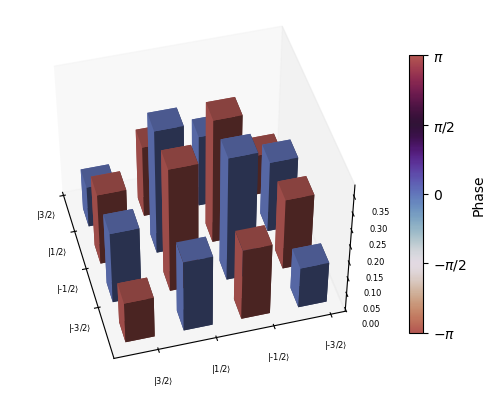

In [9]:
fig = psplt.plot_complex_density_matrix(dm_initial)

In [10]:
wQaxis = 1/(3*WQ)
times = np.arange(0, wQaxis, 1e-3)
# times=

In [11]:
h_unperturbed

[Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[21.20575041  0.          0.          0.        ]
  [ 0.          2.35619449  0.          0.        ]
  [ 0.          0.          2.35619449  0.        ]
  [ 0.          0.          0.         21.20575041]]]

In [12]:
opts = qt.Options(atol=1e-16, rtol=1e-16, rhs_reuse=False, nsteps=40000)
dms = sim.evolve(spin, h_unperturbed, dm_initial, solver='mesolve',
                        mode=mode, times=times, opts=opts, return_allstates=True)

11.1%. Run time:   0.00s. Est. time left: 00:00:00:00
20.4%. Run time:   0.00s. Est. time left: 00:00:00:00
31.5%. Run time:   0.00s. Est. time left: 00:00:00:00
40.7%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.01s. Est. time left: 00:00:00:00
61.1%. Run time:   0.01s. Est. time left: 00:00:00:00
70.4%. Run time:   0.01s. Est. time left: 00:00:00:00
81.5%. Run time:   0.01s. Est. time left: 00:00:00:00
90.7%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.02s


In [13]:
sqz_ops = sqz.populate_averge_values(dms, sqz_ops)

100%|██████████| 54/54 [00:00<00:00, 748.62it/s]


C:\Users\lemon\anaconda3\envs\pulsee_new\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\lemon\anaconda3\envs\pulsee_new\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


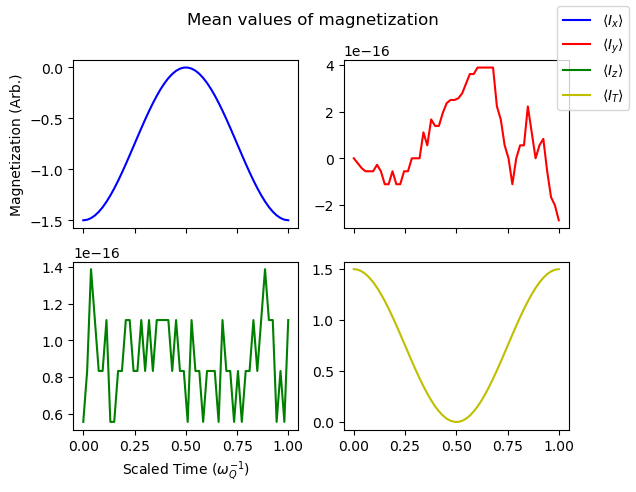

In [14]:
It = np.sqrt(sqz_ops.avIx**2+sqz_ops.avIy**2+sqz_ops.avIy**2)
sqz.plot_values([sqz_ops.avIx, sqz_ops.avIy, sqz_ops.avIz, It], times, [2,2],
                wQaxis, x_label=r'Scaled Time ($\omega_Q^{-1}$)')

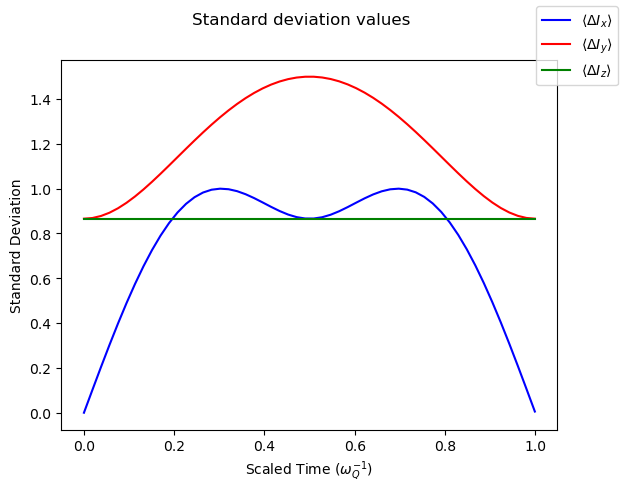

In [15]:
DIx = np.sqrt(sqz_ops.avIx2-sqz_ops.avIx**2)
DIy = np.sqrt(sqz_ops.avIy2-sqz_ops.avIy**2)
DIz = np.sqrt(sqz_ops.avIz2-sqz_ops.avIz**2)

sqz.plot_values([DIx, DIy, DIz], times, 1, wQaxis, title='Standard deviation values', 
                y_label='Standard Deviation', x_label='Scaled Time ($\omega_Q^{-1}$)', labels=['\Delta I_x', '\Delta I_y', '\Delta I_z'])

C:\Users\lemon\OneDrive\Documents\GitHub\PULSEE\pulsee\spin_squeezing.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  th = np.arctan2(np.array(r, dtype=np.float64), np.array(Jz, dtype=np.float64))
C:\Users\lemon\OneDrive\Documents\GitHub\PULSEE\pulsee\spin_squeezing.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  phi = np.arctan2(np.array(Jy, dtype=np.float64), np.array(Jx, dtype=np.float64))


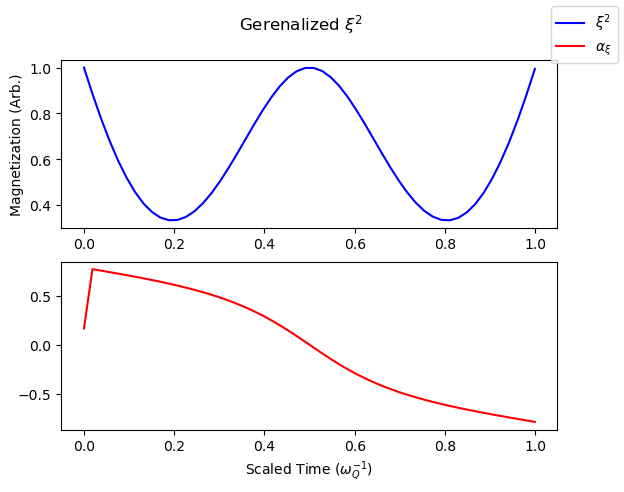

In [16]:
xi, alpha, Jn_1, Jn_2, Jn_3 = sqz.calc_squeez_param(sqz_ops, spin.I['I'], xi_sq=True, return_av_sphere=True)
sqz.plot_values([xi, alpha], times, [2, 1], wQaxis, title=r'Gerenalized $\xi^2$',
                labels=["\\xi^2", "\\alpha_\\xi"], x_label='Scaled Time ($\omega_Q^{-1}$)', put_brackets=False)

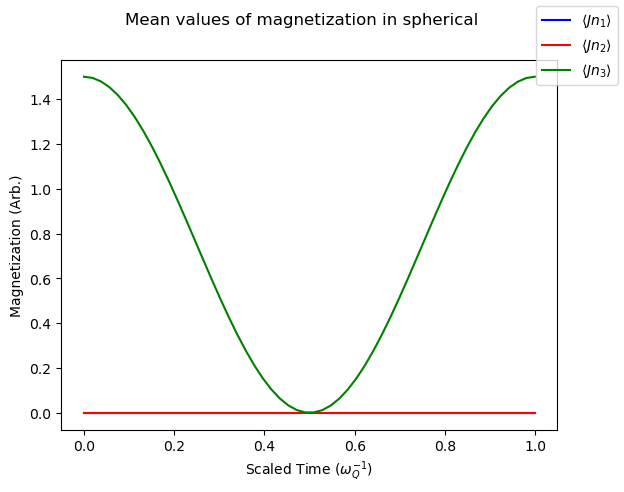

In [17]:
sqz.plot_values([Jn_1, Jn_2, Jn_3], times, 1, wQaxis, title='Mean values of magnetization in spherical',
    x_label='Scaled Time ($\omega_Q^{-1}$)', labels=['Jn_1', 'Jn_2', 'Jn_3'],put_brackets=True)